# MÔ TẢ BÀI TOÁN

- Input: Chữ số viết tay
- Output: Kết quả nhận dạng

Tham khảo: https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

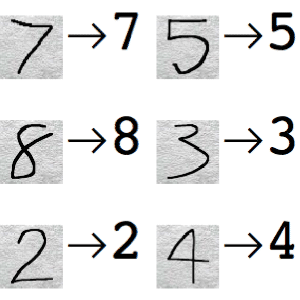

# MNIST Handwritten Digit Classification Dataset

- Các ảnh greyscale có kích thước 28x28

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


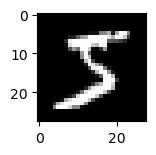

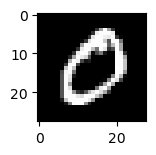

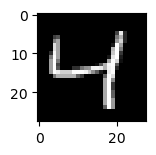

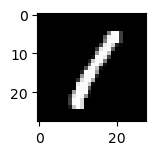

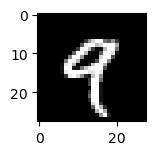

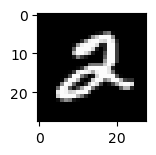

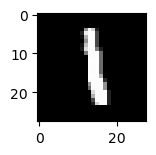

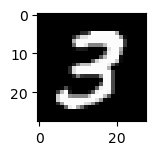

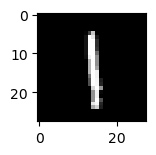

In [2]:
from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt

# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()

# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

# plot first few images
for i in range(9):
  # define subplot
  plt.subplot(330 + 1 + i)
  # plot raw pixel data
  plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
  # show the figure
  plt.show()

In [14]:
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from numpy import argmax
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import cv2 as cv
import os
import numpy as np

## Load Dataset

- we know that the images are all pre-aligned (e.g. each image only contains a hand-drawn digit), that the images all have the same square size of 28×28 pixels, and that the images are grayscale. Therefore, we can load the images and reshape the data arrays to have a single color channel.
- a one hot encoding for the class element of each sample, transforming the integer into a 10 element binary vector with a 1 for the index of the class value, and 0 values for all other classes

In [4]:
def load_dataset():
  # load dataset
  (trainX, trainY), (testX, testY) = mnist.load_data()

  # reshape dataset to have a single channel
  trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
  testX = testX.reshape((testX.shape[0], 28, 28, 1))

  # one hot encode target values
  trainY = to_categorical(trainY)
  testY = to_categorical(testY)
  return trainX, trainY, testX, testY

## Prepare Pixel Data

- We know that the pixel values for each image in the dataset are unsigned integers in the range between black and white, or 0 and 255.

- We do not know the best way to scale the pixel values for modeling, but we know that some scaling will be required.

- A good starting point is to normalize the pixel values of grayscale images, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.

In [5]:
def prep_pixels(train, test):
  # convert from integers to floats
  train_norm = train.astype('float32')
  test_norm = test.astype('float32')

  # normalize to range 0-1
  train_norm = train_norm / 255.0
  test_norm = test_norm / 255.0

  # return normalized images
  return train_norm, test_norm

## Define Model



In [6]:
def define_model():
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(10, activation='softmax'))

  # compile model
  opt = SGD(learning_rate=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  return model

## Evaluate Model

In [7]:
# evaluate a model using k-fold cross-validation
def evaluate_model(dataX, dataY, n_folds=5):
  scores, histories = list(), list()

  # prepare cross validation
  kfold = KFold(n_folds, shuffle=True, random_state=1)

  # enumerate splits
  for train_ix, test_ix in kfold.split(dataX):

    # define model
    model = define_model()

    # select rows for train and test
    trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]

    # fit model
    history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)

    # evaluate model
    _, acc = model.evaluate(testX, testY, verbose=0)
    print('> %.3f' % (acc * 100.0))

    # stores scores
    scores.append(acc)
    histories.append(history)

  return scores, histories

## Present Results

In [8]:
def summarize_diagnostics(histories):
  for i in range(len(histories)):
    # plot loss
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(histories[i].history['loss'], color='blue', label='train')
    plt.plot(histories[i].history['val_loss'], color='orange', label='test')

    # plot accuracy
    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(histories[i].history['accuracy'], color='blue', label='train')
    plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

In [9]:
def summarize_performance(scores):
  # print summary
  print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))

  # box and whisker plots of results
  plt.boxplot(scores)
  plt.show()

In [10]:
def run_test_harness():
  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)

  # evaluate model
  scores, histories = evaluate_model(trainX, trainY)

  # learning curves
  summarize_diagnostics(histories)

  # summarize estimated performance
  summarize_performance(scores)

> 98.592
> 98.658
> 98.558
> 98.842
> 98.892


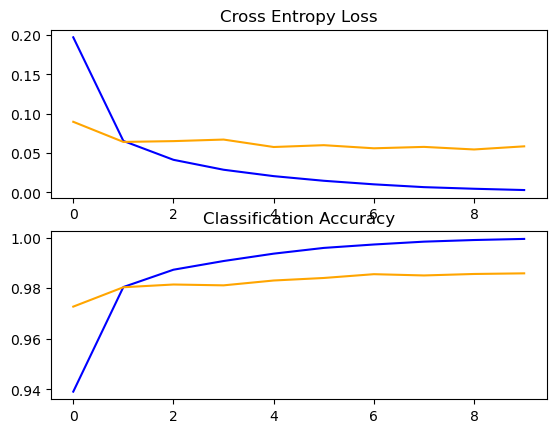

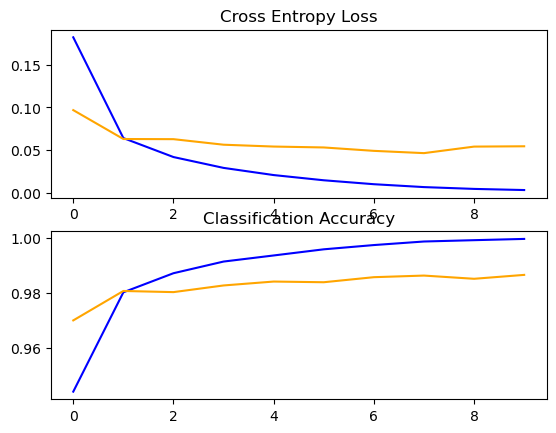

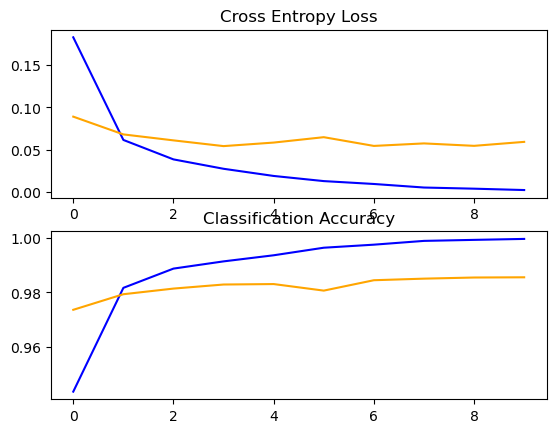

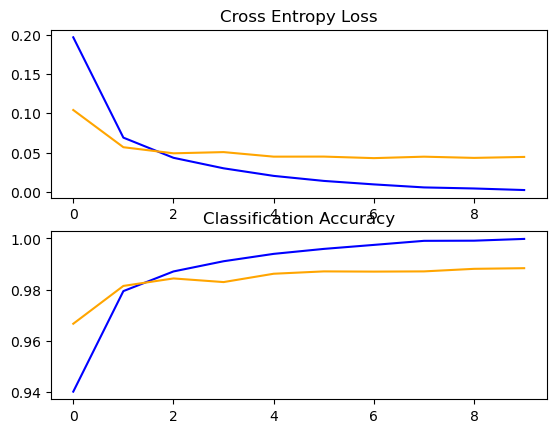

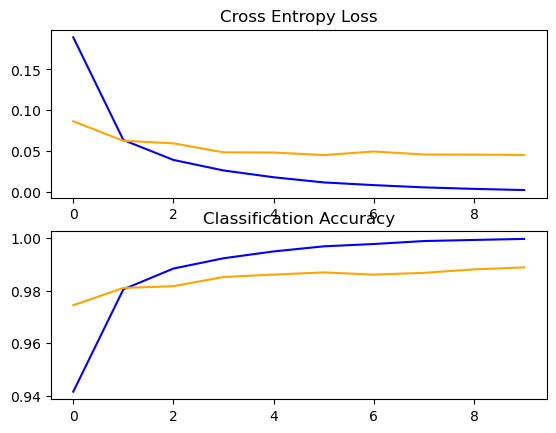

Accuracy: mean=98.708 std=0.134, n=5


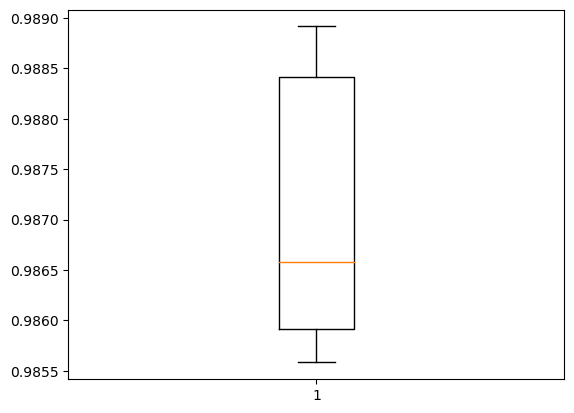

In [29]:
# entry point, run the test harness
run_test_harness()

## Save Final Model

In [11]:
# run the test harness for evaluating a model
def run_test_harness2(test_X,test_Y):

  # load dataset
  trainX, trainY, testX, testY = load_dataset()

  # prepare pixel data
  trainX, testX = prep_pixels(trainX, testX)
  # define model
  model = define_model()


  test_X = np.array(test_X)

  test_Y = np.array(test_Y)

  history=model.fit(trainX, trainY, epochs=10, batch_size=32, verbose=0)

  # tính accuracy cho tập dữ liệu test tự có 
  _, acc = model.evaluate(test_X, test_Y, verbose=0)
  print('> %.3f' % (acc * 100.0))

  # save model
  model.save('final_model.h5')

## Evaluate Final Model

In [12]:
def load_images_from_folder_link(folder_link,images):
     # Lấy đường dẫn tuyệt đối từ đường link # Kiểm tra xem đường dẫn có phải là thư mục không
    for filename in os.listdir(folder_link):  # Lấy danh sách các file trong thư mục
            filepath = os.path.join(folder_link, filename)  # Tạo đường dẫn tới file  # Kiểm tra nếu là file ảnh
            image = cv.imread(filepath)  # Đọc ảnh từ file
            resized_image = cv.resize(image, (28, 28))

            # Chuyển đổi sang ảnh xám (ảnh một kênh)
            gray_image = cv.cvtColor(resized_image, cv.COLOR_BGR2GRAY)

            # Thêm một chiều mới vào ảnh để tạo thành ảnh (28, 28, 1)
            reshaped_image = gray_image[..., np.newaxis]

            reshaped_image = 255.0-reshaped_image

            reshaped_image = reshaped_image / 255.0
            plt.imshow(reshaped_image,cmap='gray')
            plt.axis('off')  # Tắt trục
            plt.show()
            images.append(reshaped_image)  # Thêm ảnh vào danh sách

In [ ]:
folder_link0="C:\\semester_4\\Machine_learning\\LAP01\\Data_MNIST\\22521204"
images=list()
label=list()
for i in range(10):
  folder_image=folder_link0+'/'+str(i)
  load_images_from_folder_link(folder_image,images)
  label.append(i)
  label.append(i)
  label.append(i)

Accuracy final model được train trên tập dữ liệu MNIST và được đánh giá trên tập dữ liệu 22521204: 60.000%

In [16]:
run_test_harness2(images,to_categorical(label))

> 60.000


c:\Users\Admin\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
folder_link1="C:\\semester_4\\Machine_learning\\LAP01\\Data_MNIST\\22521260"
images=list()
label=list()
for i in range(10):
  folder_image=folder_link1+'/'+str(i)
  load_images_from_folder_link(folder_image,images)
  label.append(i)
  label.append(i)
  label.append(i)

Accuracy final model được train trên tập dữ liệu MNIST và được đánh giá trên tập dữ liệu 22521260: 16.667%

In [35]:
run_test_harness2(images,to_categorical(label))

> 16.667


c:\Users\Admin\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Make Prediction

In [17]:
def load_image(filename):
    # load the image
    img = load_img(filename, grayscale=True, target_size=(28, 28))

    # Convert to numpy array
    img_array = img_to_array(img)

    # Invert the image
    inverted_img_array = 255 - img_array

    # Reshape into a single sample with 1 channel
    inverted_img = inverted_img_array.reshape(1, 28, 28, 1)

    # Prepare pixel data
    inverted_img = inverted_img.astype('float32')
    inverted_img /= 255.0

    return inverted_img

In [32]:
def run_example(folder_link):
     # Lấy đường dẫn tuyệt đối từ đường link # Kiểm tra xem đường dẫn có phải là thư mục không
    for filename in os.listdir(folder_link):  # Lấy danh sách các file trong thư mục
            filepath = os.path.join(folder_link, filename)  # Tạo đường dẫn tới file  # Kiểm tra nếu là file ảnh
            image = cv.imread(filepath)  # Đọc ảnh từ file

            # chuyển ảnh thành ảnh đen trắng
            gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

            # Thêm một chiều mới vào ảnh để tạo thành ảnh (28, 28, 1)
            reshaped_image = gray_image[..., np.newaxis]

            # Đảo ngược màu 
            reshaped_image = 255.0-reshaped_image

            reshaped_image = reshaped_image / 255.0
            
            plt.imshow(reshaped_image,cmap='gray')
            plt.axis('off')  # Tắt trục
            plt.show()


            img = load_image(filepath)

            # load model
            model = load_model('final_model.h5')

            # predict the class
            predict_value = model.predict(img)

            digit = argmax(predict_value)
            print(digit)

Xuất các ảnh và predict của tập 22521260

In [ ]:
folder_link="LAP01\Data_MNIST\22521260"
images=list()
label=list()
for i in range(10):
  folder_image=folder_link+'/'+str(i)
  load_images_from_folder_link(folder_image,images)
  label.append(i)
  label.append(i)
  label.append(i)

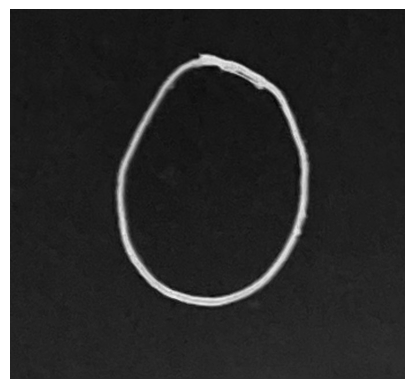

1/1 [==============================] - 0s 45ms/step
7


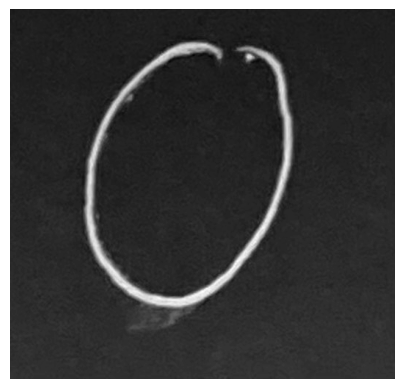

1/1 [==============================] - 0s 41ms/step
3


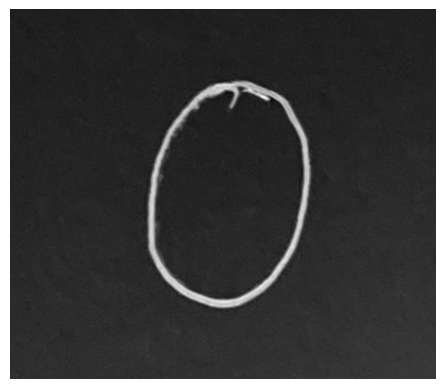

1/1 [==============================] - 0s 43ms/step
0


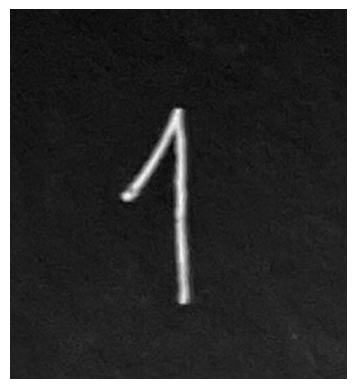

1/1 [==============================] - 0s 43ms/step
9


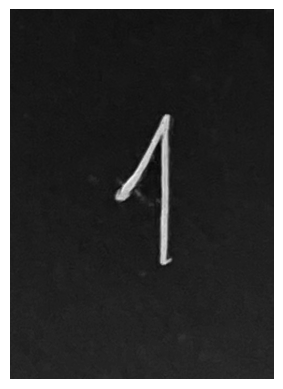

1/1 [==============================] - 0s 43ms/step
4


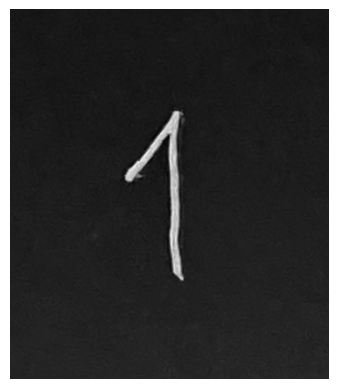

1/1 [==============================] - 0s 41ms/step
9


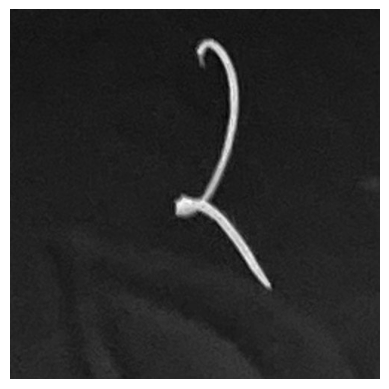

1/1 [==============================] - 0s 46ms/step
6


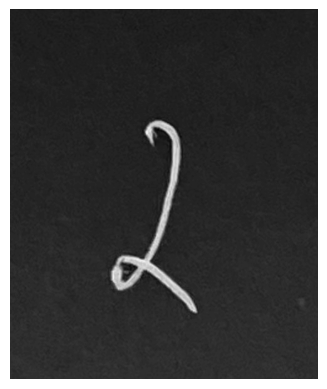

1/1 [==============================] - 0s 41ms/step
8


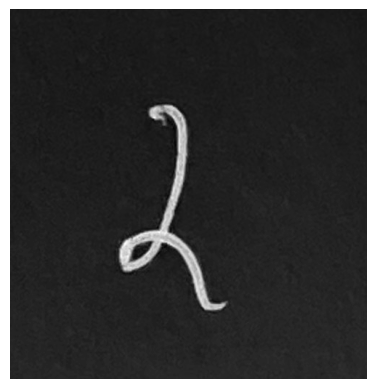

1/1 [==============================] - 0s 43ms/step
8


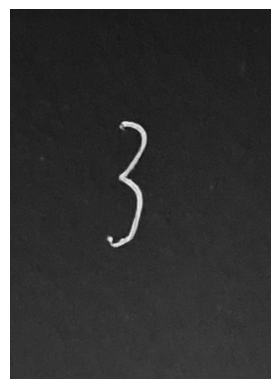

1/1 [==============================] - 0s 39ms/step
9


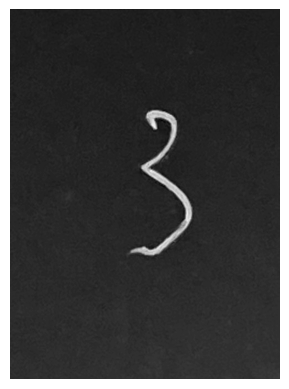

1/1 [==============================] - 0s 40ms/step
8


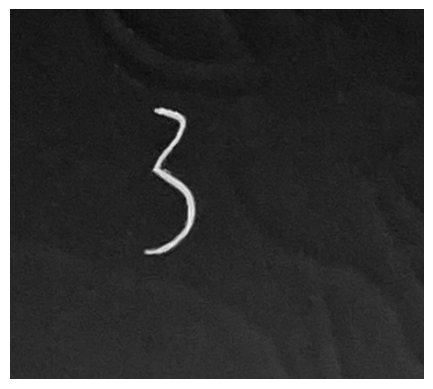

1/1 [==============================] - 0s 41ms/step
5


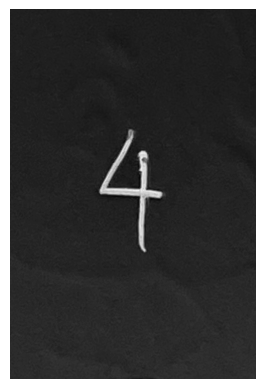

1/1 [==============================] - 0s 49ms/step
9


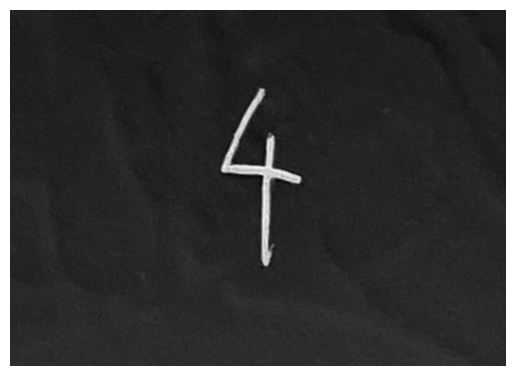

1/1 [==============================] - 0s 42ms/step
1


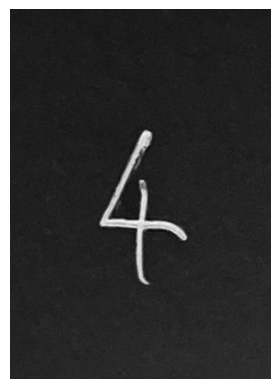

1/1 [==============================] - 0s 41ms/step
4


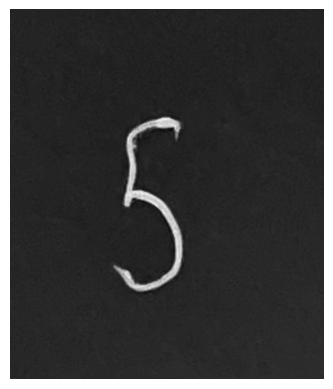

1/1 [==============================] - 0s 40ms/step
5


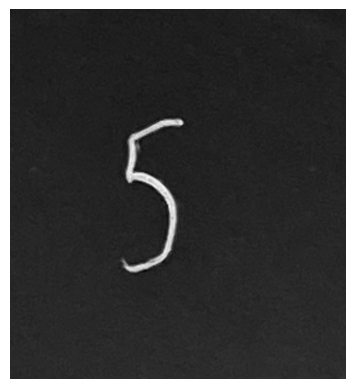

1/1 [==============================] - 0s 40ms/step
5


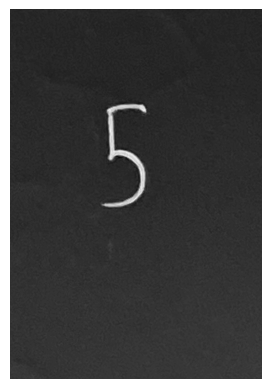

1/1 [==============================] - 0s 41ms/step
9


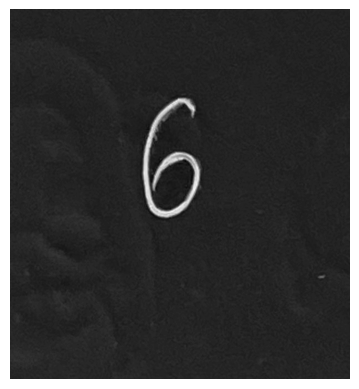

1/1 [==============================] - 0s 42ms/step
9


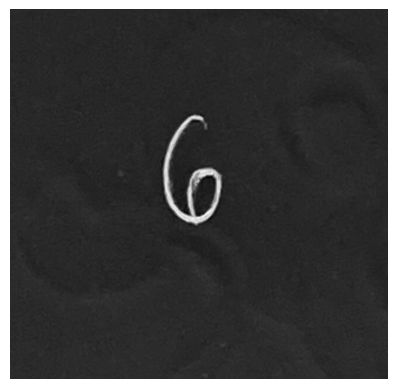

1/1 [==============================] - 0s 44ms/step
9


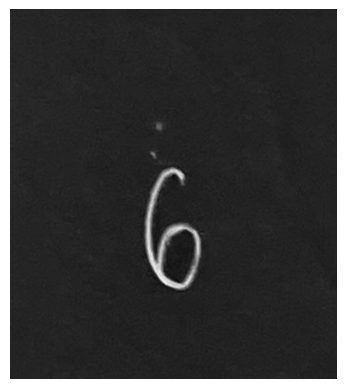

1/1 [==============================] - 0s 43ms/step
3


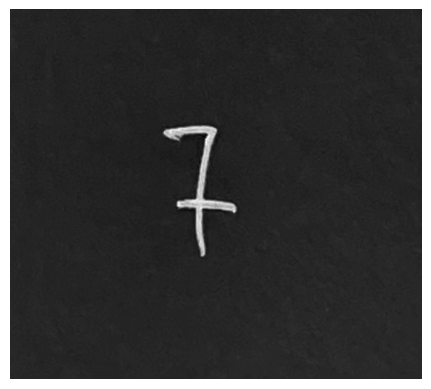

1/1 [==============================] - 0s 44ms/step
9


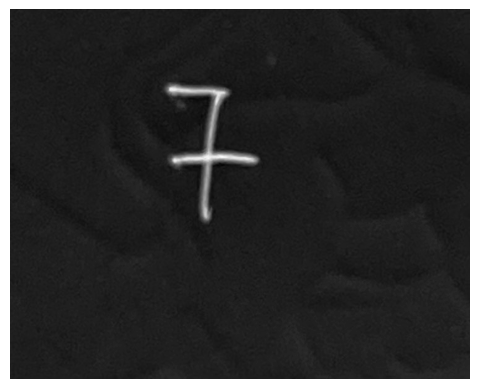

1/1 [==============================] - 0s 44ms/step
3


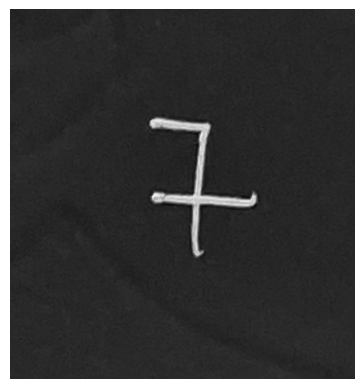

1/1 [==============================] - 0s 45ms/step
9


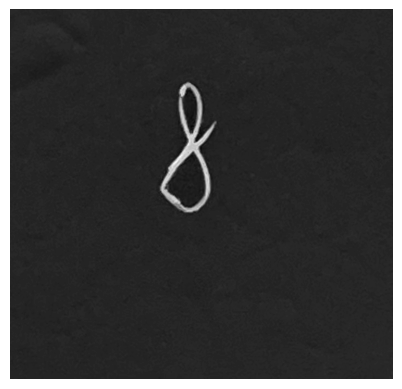

1/1 [==============================] - 0s 43ms/step
9


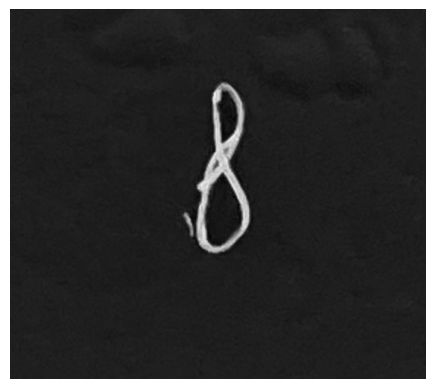

1/1 [==============================] - 0s 46ms/step
9


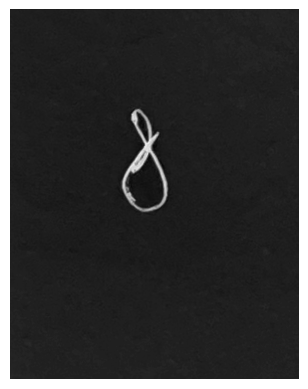

1/1 [==============================] - 0s 43ms/step
9


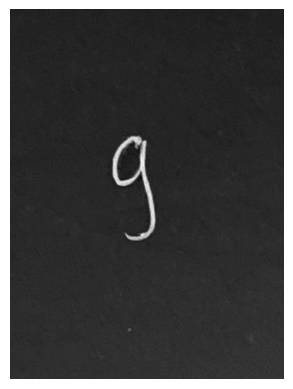

1/1 [==============================] - 0s 43ms/step
1


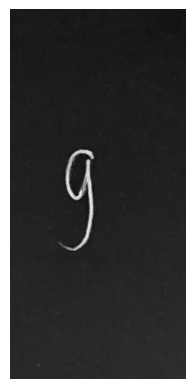

1/1 [==============================] - 0s 45ms/step
5


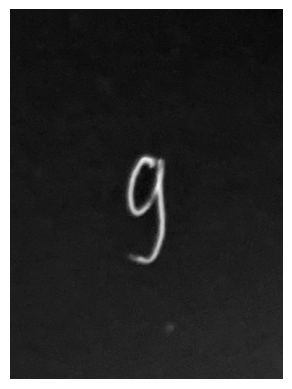

1/1 [==============================] - 0s 43ms/step
1


In [39]:
for i in range(10):
  folder_image=folder_link+'/'+str(i)
  run_example(folder_image)

Xuất các ảnh và predict của tập 22521204

In [ ]:
folder_link="LAP01\Data_MNIST\22521204"
images=list()
label=list()
for i in range(10):
  folder_image=folder_link+'\\'+str(i)
  load_images_from_folder_link(folder_image,images)
  label.append(i)
  label.append(i)
  label.append(i)

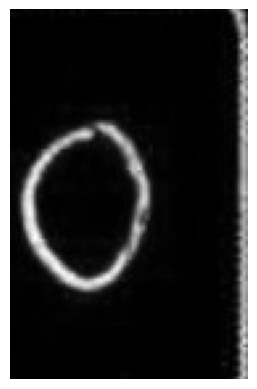

1/1 [==============================] - 0s 41ms/step
3


c:\Users\Admin\anaconda3\lib\site-packages\keras\src\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


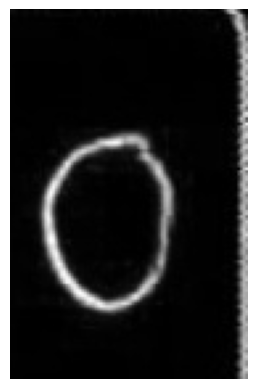

1/1 [==============================] - 0s 45ms/step
5


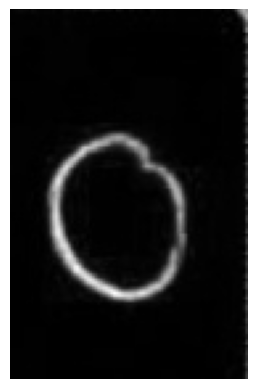

1/1 [==============================] - 0s 44ms/step
5


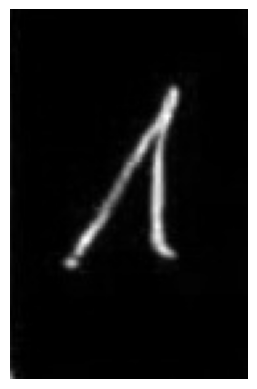

1/1 [==============================] - 0s 43ms/step
4


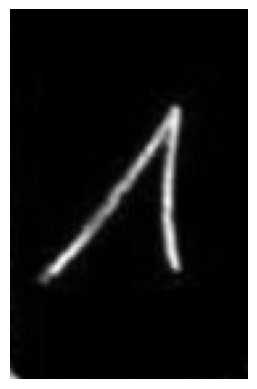

1/1 [==============================] - 0s 43ms/step
7


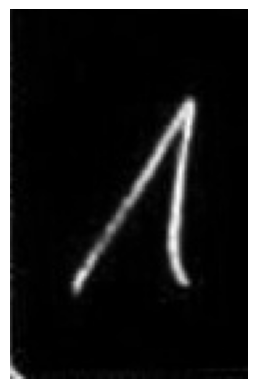

1/1 [==============================] - 0s 72ms/step
1


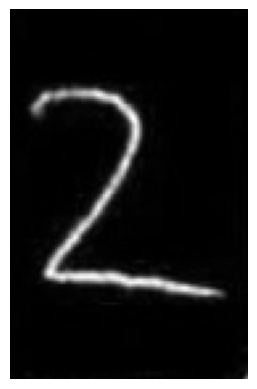

1/1 [==============================] - 0s 45ms/step
2


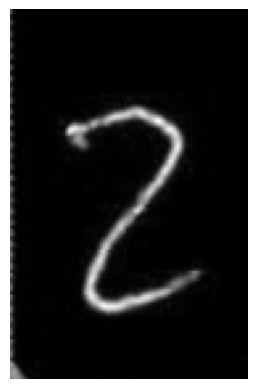

1/1 [==============================] - 0s 42ms/step
2


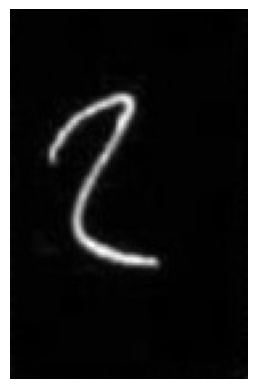

1/1 [==============================] - 0s 43ms/step
3


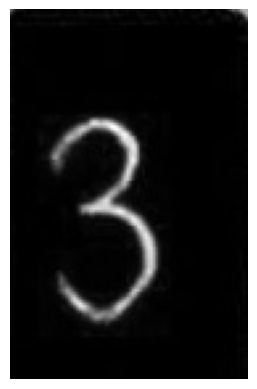

1/1 [==============================] - 0s 41ms/step
3


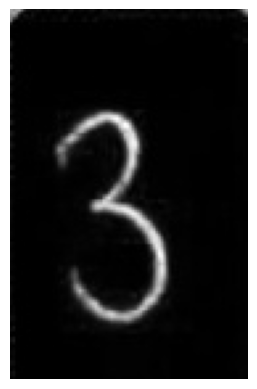

1/1 [==============================] - 0s 40ms/step
3


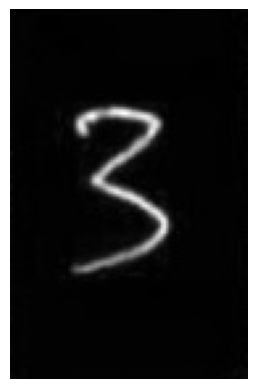

1/1 [==============================] - 0s 43ms/step
3


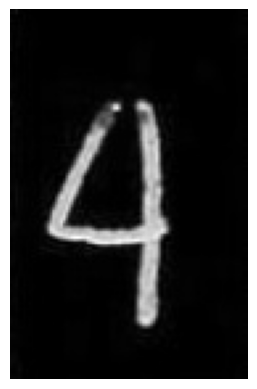

1/1 [==============================] - 0s 40ms/step
4


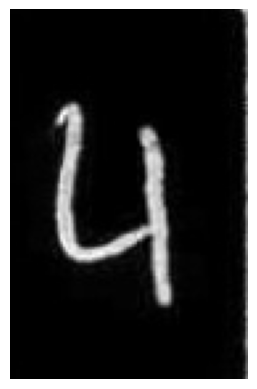

1/1 [==============================] - 0s 42ms/step
4


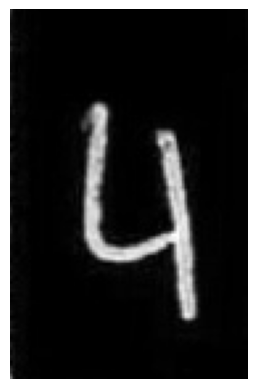

1/1 [==============================] - 0s 44ms/step
4


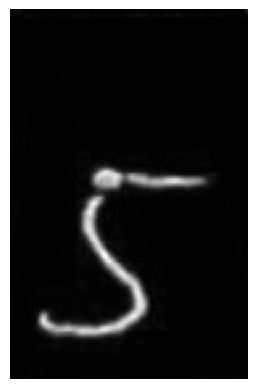

1/1 [==============================] - 0s 40ms/step
5


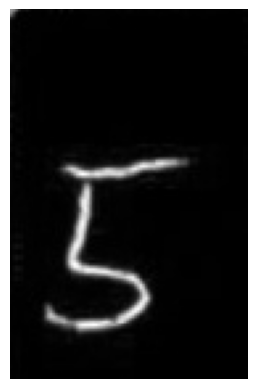

1/1 [==============================] - 0s 41ms/step
5


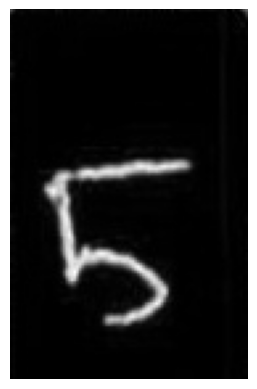

1/1 [==============================] - 0s 46ms/step
5


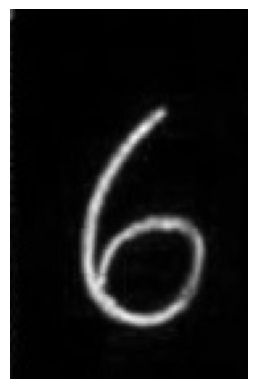

1/1 [==============================] - 0s 44ms/step
6


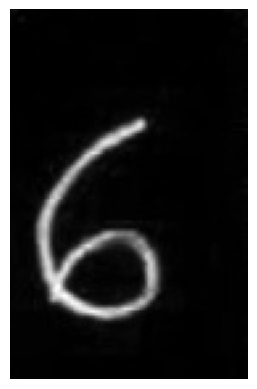

1/1 [==============================] - 0s 44ms/step
3


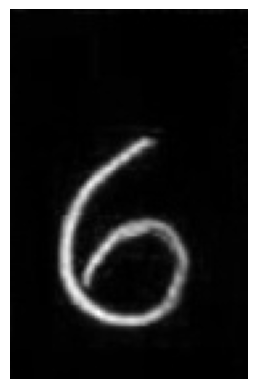

1/1 [==============================] - 0s 44ms/step
5


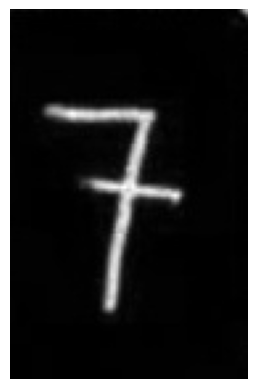

1/1 [==============================] - 0s 44ms/step
7


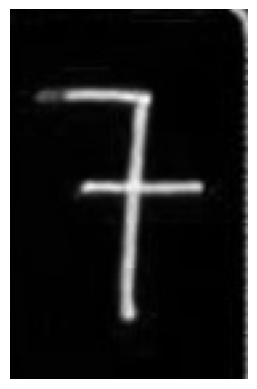

1/1 [==============================] - 0s 41ms/step
7


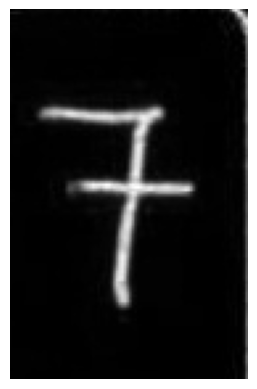

1/1 [==============================] - 0s 45ms/step
7


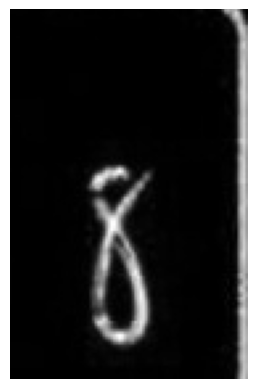

1/1 [==============================] - 0s 43ms/step
5


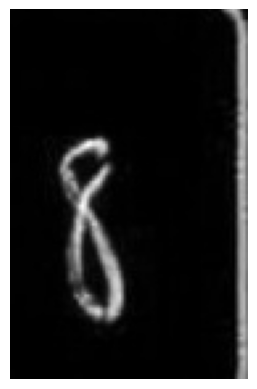

1/1 [==============================] - 0s 42ms/step
0


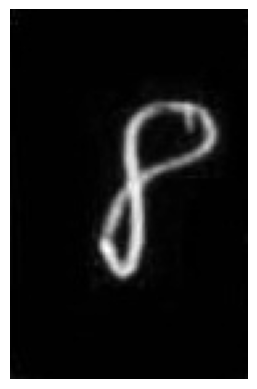

1/1 [==============================] - 0s 42ms/step
5


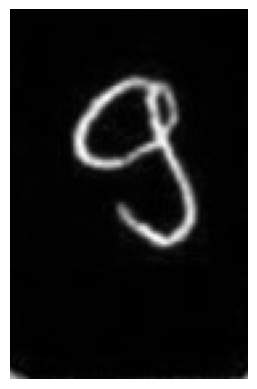

1/1 [==============================] - 0s 45ms/step
9


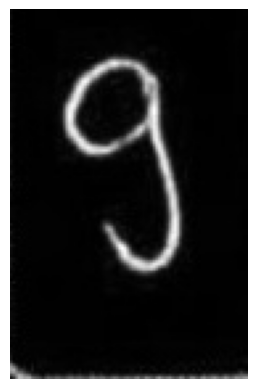

1/1 [==============================] - 0s 44ms/step
7


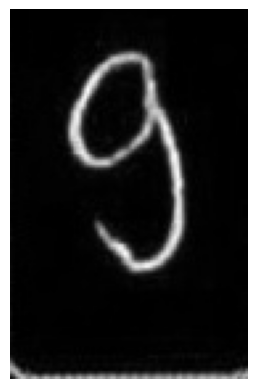

1/1 [==============================] - 0s 42ms/step
2


In [37]:
for i in range(10):
  folder_image=folder_link+'\\'+str(i)
  run_example(folder_image)

vì ảnh MNIST để train là ảnh nền đen, ảnh trắng nên khi test ảnh đổi từ ảnh màu sang ảnh đen trắng và đảo ngược sáng